## Table of Contents:
* [Introduction](#Introduction)
* [Import Libraries](#import-libraries)
* [Selecting a Single Stock](#selecting_a_single_stock)
* [KPSS Test for Stationarity Test](#kpss)
* [ADF Test for Stationarity Test](#adf)
* [Selecting the Order of Differencing(d)](#d)
* [Selecting the Order of AR(p)](#p)
* [Selecting the Order of MA(q)](#q)
* [Fitting the ARIMA model](#fit)
* [Residual Plot](#resid)
* [Out-of-time Cross Validation](#otcv)
* [Accuracy Metrics](#acc_met)
* [Auto ARIMA Forecasting](#auto)

## Introduction <a class="anchor" id="Introduction"></a>

## Stock Price Forecasting

ARIMA, short for 'Auto Regressive Integrated Moving Average' is actually a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.
In this post, we build an optimal ARIMA model from scratch

## Importing the necessary libraries <a class="anchor" id="import-libraries"></a>

In [150]:
import pandas as pd
import datetime as dt
from datetime import datetime
from urllib.error import HTTPError
import pandas_market_calendars as mcal
import requests
from bs4 import BeautifulSoup
import re
import csv
import warnings
import numpy as np
from sklearn import datasets, linear_model, metrics
import pickle
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,plot_predict
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pmdarima as pm
import scipy.stats as stats
from scipy.stats import boxcox

import pandas as pd
import pandas
import datetime as dt
from datetime import datetime
from urllib.error import HTTPError
import pandas_market_calendars as mcal
import requests
from bs4 import BeautifulSoup
import re
import warnings
import csv
import numpy as np
from sklearn import datasets, linear_model, metrics
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error

## Picking a single stock data<a class="anchor" id="selecting_a_single_stock"></a>

Here we have chosen Amazon stock price from 2006 to 2018 and selected mainly two columns: closing price and first differening of closing price, i.e., daily returns

In [156]:
with open('cons_cyc_df_years.pickle', 'rb') as handle:
    cons_cyc_df_years = pickle.load(handle)

In [157]:
amazon_cl = cons_cyc_df_years['AMZN'][['Close']]
amazon_return = cons_cyc_df_years['AMZN'][['Daily_Returns']]
amazon_cl

,Close
2006-01-03,47.58
2006-01-04,47.25
2006-01-05,47.65
2006-01-06,47.87
2006-01-09,47.08
...,...
2017-11-06,1120.66
2017-11-07,1123.17
2017-11-08,1132.88
2017-11-09,1129.13


In [158]:
#sm.stats.acorr_ljungbox(amazon_return.values, lags=[15], return_df=True, boxpierce = True)

## KPSS test for stationarity<a class="anchor" id="kpss"></a>

KPSS is test to check for stationarity in the presence of a deterministic trend. 

Null Hypothesis(H0): Time series is stationary around a deterministic trend. 

Alternative Hypothesis(Ha): Time series has unit root, i.e., non-statinary. 


In [159]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return (kpss_output)

df = kpss_test(amazon_cl.values)
df1 = kpss_test(amazon_return.values)
print (df, df1)

Results of KPSS Test:
Results of KPSS Test:
Test Statistic            1.70966
p-value                   0.01000
Lags Used                32.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64 Test Statistic            0.031492
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The p-value reported by the test is the probability score based on which you can decide whether to reject the null hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.
So, here we can say that amazon closing price is not stationary(rejecting the H0) and for amazon return price, we fail to reject the null hypothesis, i.e., time series is sationatinary. 


In [194]:
#mydf = pd.DataFrame(columns=df.index.tolist())
#myseries = pd.Series(df.values, index = mydf.columns)
#mydf = mydf.append(df, ignore_index = True)

## ADF test for stationarity<a class="anchor" id="adf"></a>

ADF test is for checking the stationarity.
H0: The null hypothesis of the ADF test is that the time series is non-stationary.
Ha: The alternative hypothesis of the ADF test is that the time series is stationary.     

In [160]:
result_closing = adfuller(amazon_cl.values)
result_return = adfuller(amazon_return.values)

print (result_closing)
print (result_return)

(2.9097423703974257, 1.0, 29, 2957, {'1%': -3.432563387143659, '5%': -2.8625179291294662, '10%': -2.5672905782716513}, 19642.916397494984)
(-41.231323939010906, 0.0, 1, 2985, {'1%': -3.432542607157588, '5%': -2.8625087513967085, '10%': -2.5672856921402096}, -13356.912840478057)


## How to find the order of differencing (d)<a class="anchor" id="d"></a>

The purpose of differencing it to make the time series stationary. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.
If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.



<Figure size 960x360 with 0 Axes>

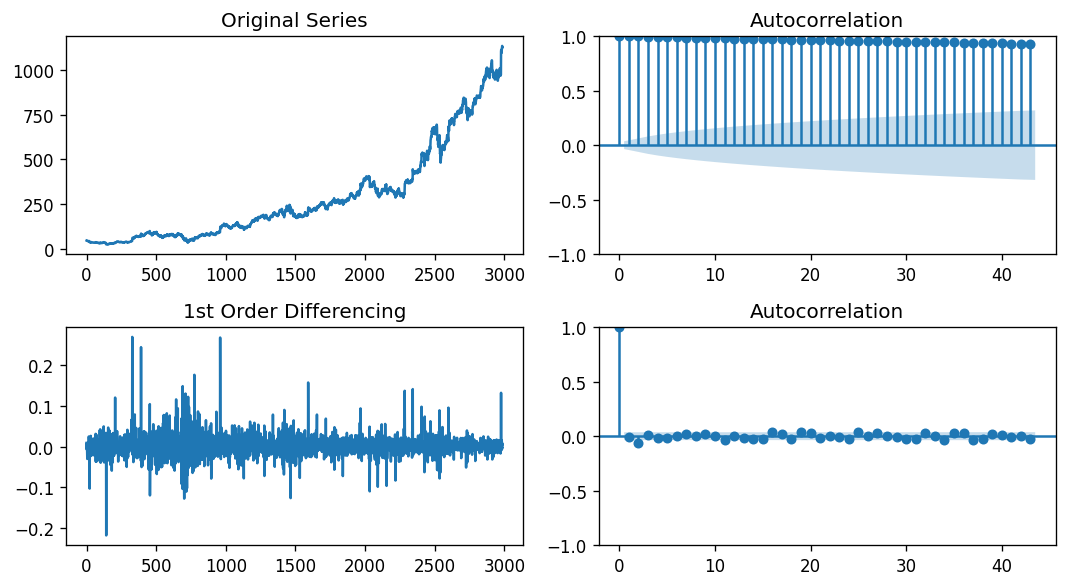

In [161]:
plt.clf()
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(amazon_cl.values)
axes[0, 0].set_title('Original Series')
#plot_acf(amazon_cl.values, ax=axes[0, 1])
sm.graphics.tsa.plot_acf(amazon_cl.values, ax=axes[0, 1], lags = 43)

# 1st Differencing
axes[1, 0].plot(amazon_return.values)
axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(amazon_return.values, ax=axes[1, 1], lags = 43)
fig.tight_layout()
plt.show()


From the stationarity tests (KPSS and ADF) and the correlation plots above, it can be said that 
closing price of Amazon stock price is not stationary. However, after first differencing (daily returns), it looks like the stock price follows stationarity.
So, it seems like differencing(d) = 1 will serve the purpose, i.e., data follows the stationarity.

## How to find the order of AR term (p)<a class="anchor" id="p"></a>

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1080x600 with 0 Axes>

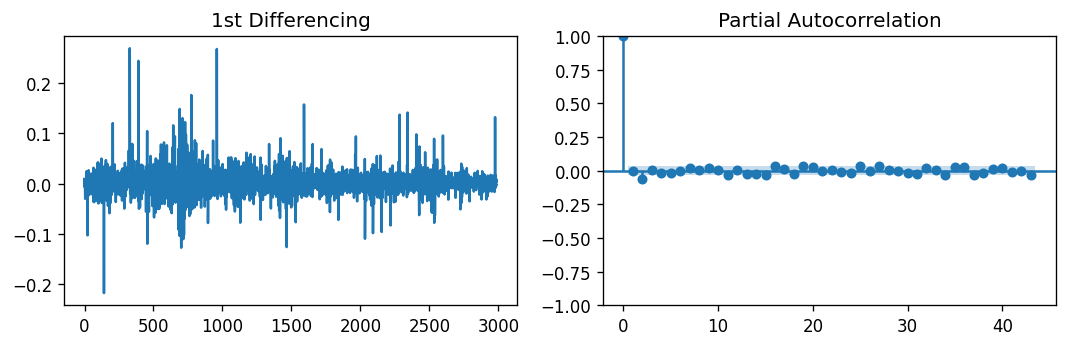

In [162]:
plt.clf()
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(amazon_return.values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
sm.graphics.tsa.plot_pacf(amazon_return.values, ax = axes[1], lags = 43)
fig.tight_layout()
plt.show()

You can observe that the PACF lag 2 is slightly significant, just managing to cross the significance limit (blue region). So, lets start with p as 2.

## How to find the order of MA term (q)<a class="anchor" id="q"></a>

Just like how we looked at the PACF plot for the number of AR terms, we can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
From the above ACF plot, it does not seem like there is any significant lags. However, there 
is a very small lag appears to be minutely significant at lag = 2. 
So, lets start to model with (2,1,2) order and then we will play around and see which model fits the best. 


## Building ARIMA model<a class="anchor" id="fit"></a>

Now that the values of p, d and q have been determined, next we can fit the ARIMA model. 

In [152]:
#amazon_cl['Close'],lam = boxcox(amazon_cl['Close'])

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [163]:

model = ARIMA(amazon_cl, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2987
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9911.621
Date:                Fri, 18 Feb 2022   AIC                          19833.243
Time:                        12:26:55   BIC                          19863.251
Sample:                             0   HQIC                         19844.039
                               - 2987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0708      0.162      6.599      0.000       0.753       1.389
ar.L2         -0.5176      0.172     -3.016      0.003      -0.854      -0.181
ma.L1         -1.0466      0.165     -6.332      0.0

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice here the coefficient of all the terms are significant and the P-Value in ‘P>|z|’ column is highly significant (<0.05).


## Residual plot<a class="anchor" id="resid"></a>

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

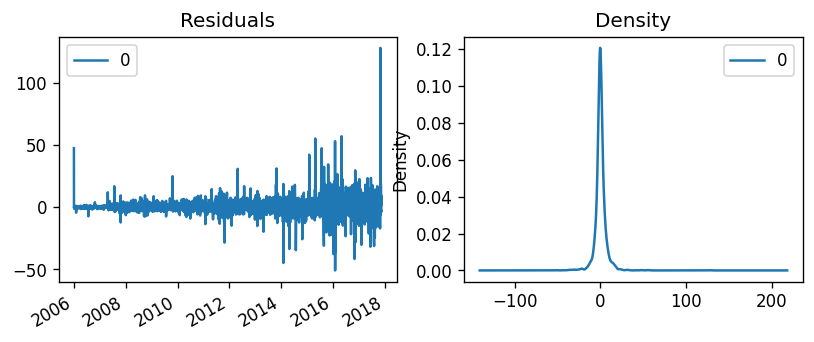

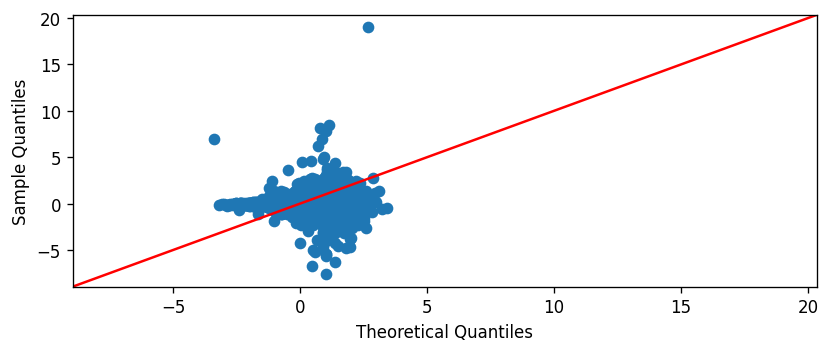

In [166]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(8,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
sm.qqplot(residuals,fit=True,line = '45',dist=stats.norm)
plt.show()


The residual errors seem fine with near zero mean and uniform variance.

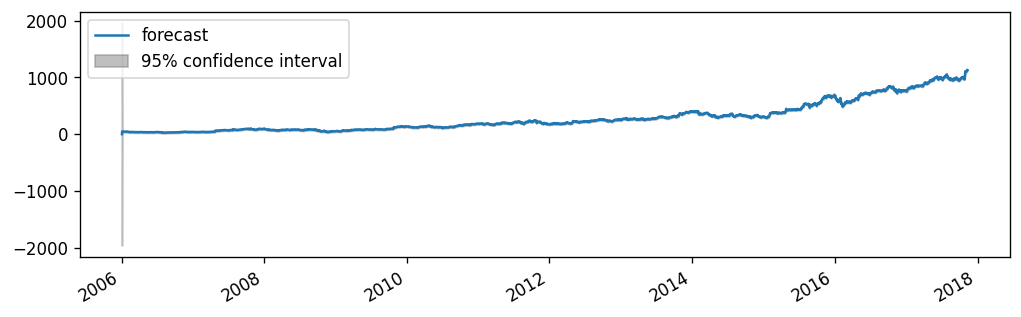

In [165]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(10, 3))
fig = plot_predict(model_fit, ax = ax)


In [143]:
amazon_cl_ser = amazon_cl.squeeze()

In [10]:
def arima_model_eval(data, arima_order):
    split = int(len(data) * 0.8)
    train1 = data[0:split]
    test1 = data[split:len(data)]
    history = [x for x in train1]
    prediction = []
    for i in range(len(test1)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        model_forecast = model_fit.forecast()
        prediction.append(model_forecast[0])
        obs = test1[i]
        history.append(obs)
    rmse = mean_squared_error(test1,prediction)
    return (rmse)

In [11]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf") , None
    for p in range(len(p_values)):
        for d in range(len(d_values)):
            for q in range(len(q_values)):
                order = (p,d,q)
                mse = arima_model_eval(dataset, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [12]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0,3)]
d_values = [x for x in range(0,3)]
q_values = [x for x in range(0,3)]


In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Line that is not converging
    evaluate_models(amazon,p_values,d_values,q_values)

ARIMA(0, 0, 0) MSE=0.000


## ARIMA model manually using Out-of-Time Cross validation<a class="anchor" id="otcv"></a>

In [167]:
train_ind = int(np.round(amazon_return_ser.shape[0]*0.85))
train = amazon_cl.iloc[:train_ind]
test = amazon_cl[train_ind:]
model = ARIMA(train, order=(1, 1, 1)) 
fitted = model.fit()
fc_ser = fitted.forecast(448, alpha = 0.05)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

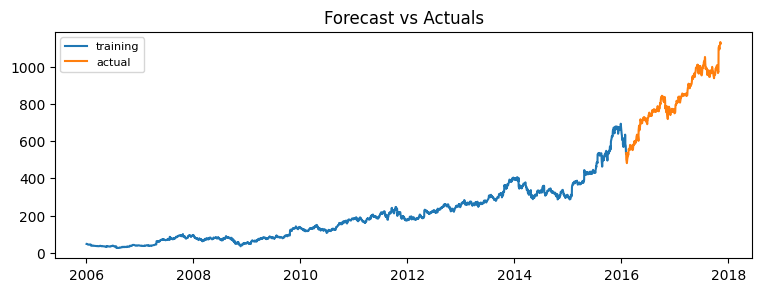

In [168]:
plt.figure(figsize=(9,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(fc_ser, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

 

## Accuracy Metrics for time series analysis<a class="anchor" id="acc_met"></a>

In [169]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'acf' : acf1, 
            'corr':corr, 'minmax':minmax})

test_arr = np.array(list(map(lambda x: x[0], test.values)))
forecast_accuracy(fc_ser.values, test_arr)

{'mape': 0.32945075576666955,
 'me': -286.6933971302973,
 'mae': 287.8184600329942,
 'mpe': -0.3271814959152503,
 'rmse': 320.2251299110364,
 'acf': 0.9871006754487759,
 'corr': 0.21896692036737914,
 'minmax': 0.3293698468638466}

## Auto Arima Forecast in Python (PMDARIMA)<a class="anchor" id="auto"></a>

In [170]:
model_auto = pm.auto_arima(amazon_cl.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19829.779, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19827.581, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19828.098, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19828.044, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19834.262, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.961 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2987
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9911.790
Date:                Fri, 18 Feb 2022   AIC                          19827.581
Time:                        12:27:54   BIC                          19839.584
Sample:                             0   HQIC                         19831.899
                               - 2987                                  

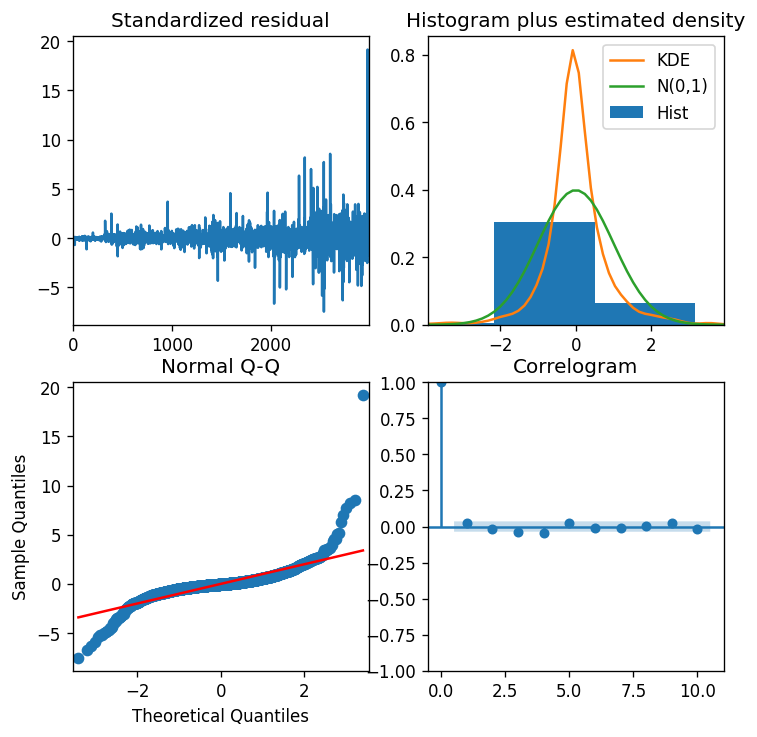

In [171]:
model_auto.plot_diagnostics(figsize=(7,7))
fig.tight_layout()
plt.show()